# 간단한 컨브넷 밑바닥 부터 훈련시키기 

In [10]:
# 네트워크 구성 

from keras import layers 
from keras import models 

model = models.Sequential() 
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3))) # 입력 특성 맵에 적용 할 필터 수: 32, 윈도우 사이즈, 활성화함수, 입력 데이터 규격: 150*150, RGB 3 채널 
model.add(layers.MaxPooling2D((2,2))) # 최대 풀링 연산 적용할 윈도우 사이즈 - 다운샘플링(크기 축소)
model.add(layers.Conv2D(64, (3,3), activation='relu')) # 입력 특성 맵에 적용할 필터 수:64, 윈도우 사이즈, 활성화 함수 
model.add(layers.MaxPooling2D((2,2))) # 윈도우 사이즈 
model.add(layers.Conv2D(128, (3,3), activation='relu')) # 필터 수: 128개, 윈도우 사이즈 
model.add(layers.MaxPooling2D((2,2))) # 윈도우 사이즈 
model.add(layers.Conv2D(128, (3,3), activation='relu')) # 필터 수: 128개, 윈도우 사이즈 
model.add(layers.MaxPooling2D(2,2)) # 윈도우 사이즈 
# 여기까지 합성곱 기반 층(지역 패턴 추출 층)

# 여기서부터 완전 연결 층(전역 패턴 추출, 분류기)
model.add(layers.Flatten()) # 1차원 텐서(벡터)로 변환
model.add(layers.Dense(512, activation='relu')) # 512차원 벡터공간에 투영 
model.add(layers.Dense(1, activation='sigmoid'))

In [3]:
model.summary()
# 1. 150*150 입력 이미지에서 3*3 윈도우 슬라이딩하면서 3*3 패치 추출 -> 32개 필터에 대해 합성곱 -> 148*148*32 
# 2. 2*2 윈도우 1의 출력 특성 맵에 적용해서 패치 구역 별 최댓값만 추출 -> 출력 특성 맵 크기 절반으로 줄어든다 -> 74*74*32 
# 3. 2의 출력 특성 맵에서 다시 3*3 패치 추출 -> 64개 필터에 대해 합성곱 -> 72*72*64 
# 4. 2 처럼 최대 풀링 연산 3 출력에 적용 -> 출력 특성 맵 크기 절반으로 줄어든다 -> 36*36*64 
# 5. 3*3 패치, 128개 필터에 대해 합성곱 -> 34*34*128 
# 6. 최대 풀링 연산 적용 -> 17*17*128 
# 7. 3*3 패치, 128개 필터에 대해 합성곱 -> 15*15*128 
# 8. 최대 풀링 연산 적용 -> 7*7*128 
# 9. 완전 연결 분류기 주입 위해 1차원 텐서(벡터)로 변환하는 층 
# 10. 512차원 벡터공간에 투영 
# 11. 1차원 벡터공간으로 차원축소 후 시그모이드 함수 적용 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [11]:
# 모델 컴파일 

from keras import optimizers 

model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.adam_v2.Adam(learning_rate=0.001), 
    metrics=['acc']
)

In [12]:
# 데이터 전처리 

from keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator(rescale=1./255) # 스케일 1/255 로 조정 , 부동소수점 형태로 변환 
test_datagen = ImageDataGenerator(rescale=1./255) # 스케일 조정 

train_generator = train_datagen.flow_from_directory(
    '/Users/kibeomkim/Desktop/cats_and_dogs_small/train', 
    target_size=(150, 150), # 네트워크 입력 규격에 맞게 크기 변환 
    batch_size=20, # 1에폭 동안 투입 할 데이터 묶음 
    class_mode = 'binary' # 데이터가 이진 레이블임. 
)

valid_generator = test_datagen.flow_from_directory(
    '/Users/kibeomkim/Desktop/cats_and_dogs_small/test', 
    target_size=(150,150), 
    batch_size=20, 
    class_mode='binary'
)

# 모델 훈련 

history = model.fit_generator(
    train_generator, 
    steps_per_epoch= 100, # 20*100 = 총 훈련 데이터 갯수 
    epochs = 30 , 
    validation_data = valid_generator, 
    validation_steps = 50 
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30


2022-02-26 15:16:47.597129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.7003 - acc: 0.4870

2022-02-26 15:16:53.645505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 8s 73ms/step - loss: 0.7003 - acc: 0.4870 - val_loss: 0.6925 - val_acc: 0.5100
Epoch 2/30
100/100 [==============================] - 7s 68ms/step - loss: 0.6868 - acc: 0.5255 - val_loss: 0.6596 - val_acc: 0.5750
Epoch 3/30
100/100 [==============================] - 7s 68ms/step - loss: 0.6874 - acc: 0.5200 - val_loss: 0.6886 - val_acc: 0.5310
Epoch 4/30
100/100 [==============================] - 7s 68ms/step - loss: 0.6657 - acc: 0.5705 - val_loss: 0.6784 - val_acc: 0.6160
Epoch 5/30
100/100 [==============================] - 7s 68ms/step - loss: 0.6484 - acc: 0.5975 - val_loss: 0.6595 - val_acc: 0.6280
Epoch 6/30
100/100 [==============================] - 7s 68ms/step - loss: 0.6319 - acc: 0.6355 - val_loss: 0.6335 - val_acc: 0.6380
Epoch 7/30
100/100 [==============================] - 7s 69ms/step - loss: 0.5514 - acc: 0.7060 - val_loss: 0.6933 - val_acc: 0.6620
Epoch 8/30
100/100 [==============================] - 7s 68ms/step - loss: 0.527

# 과대적합 나타났다. 

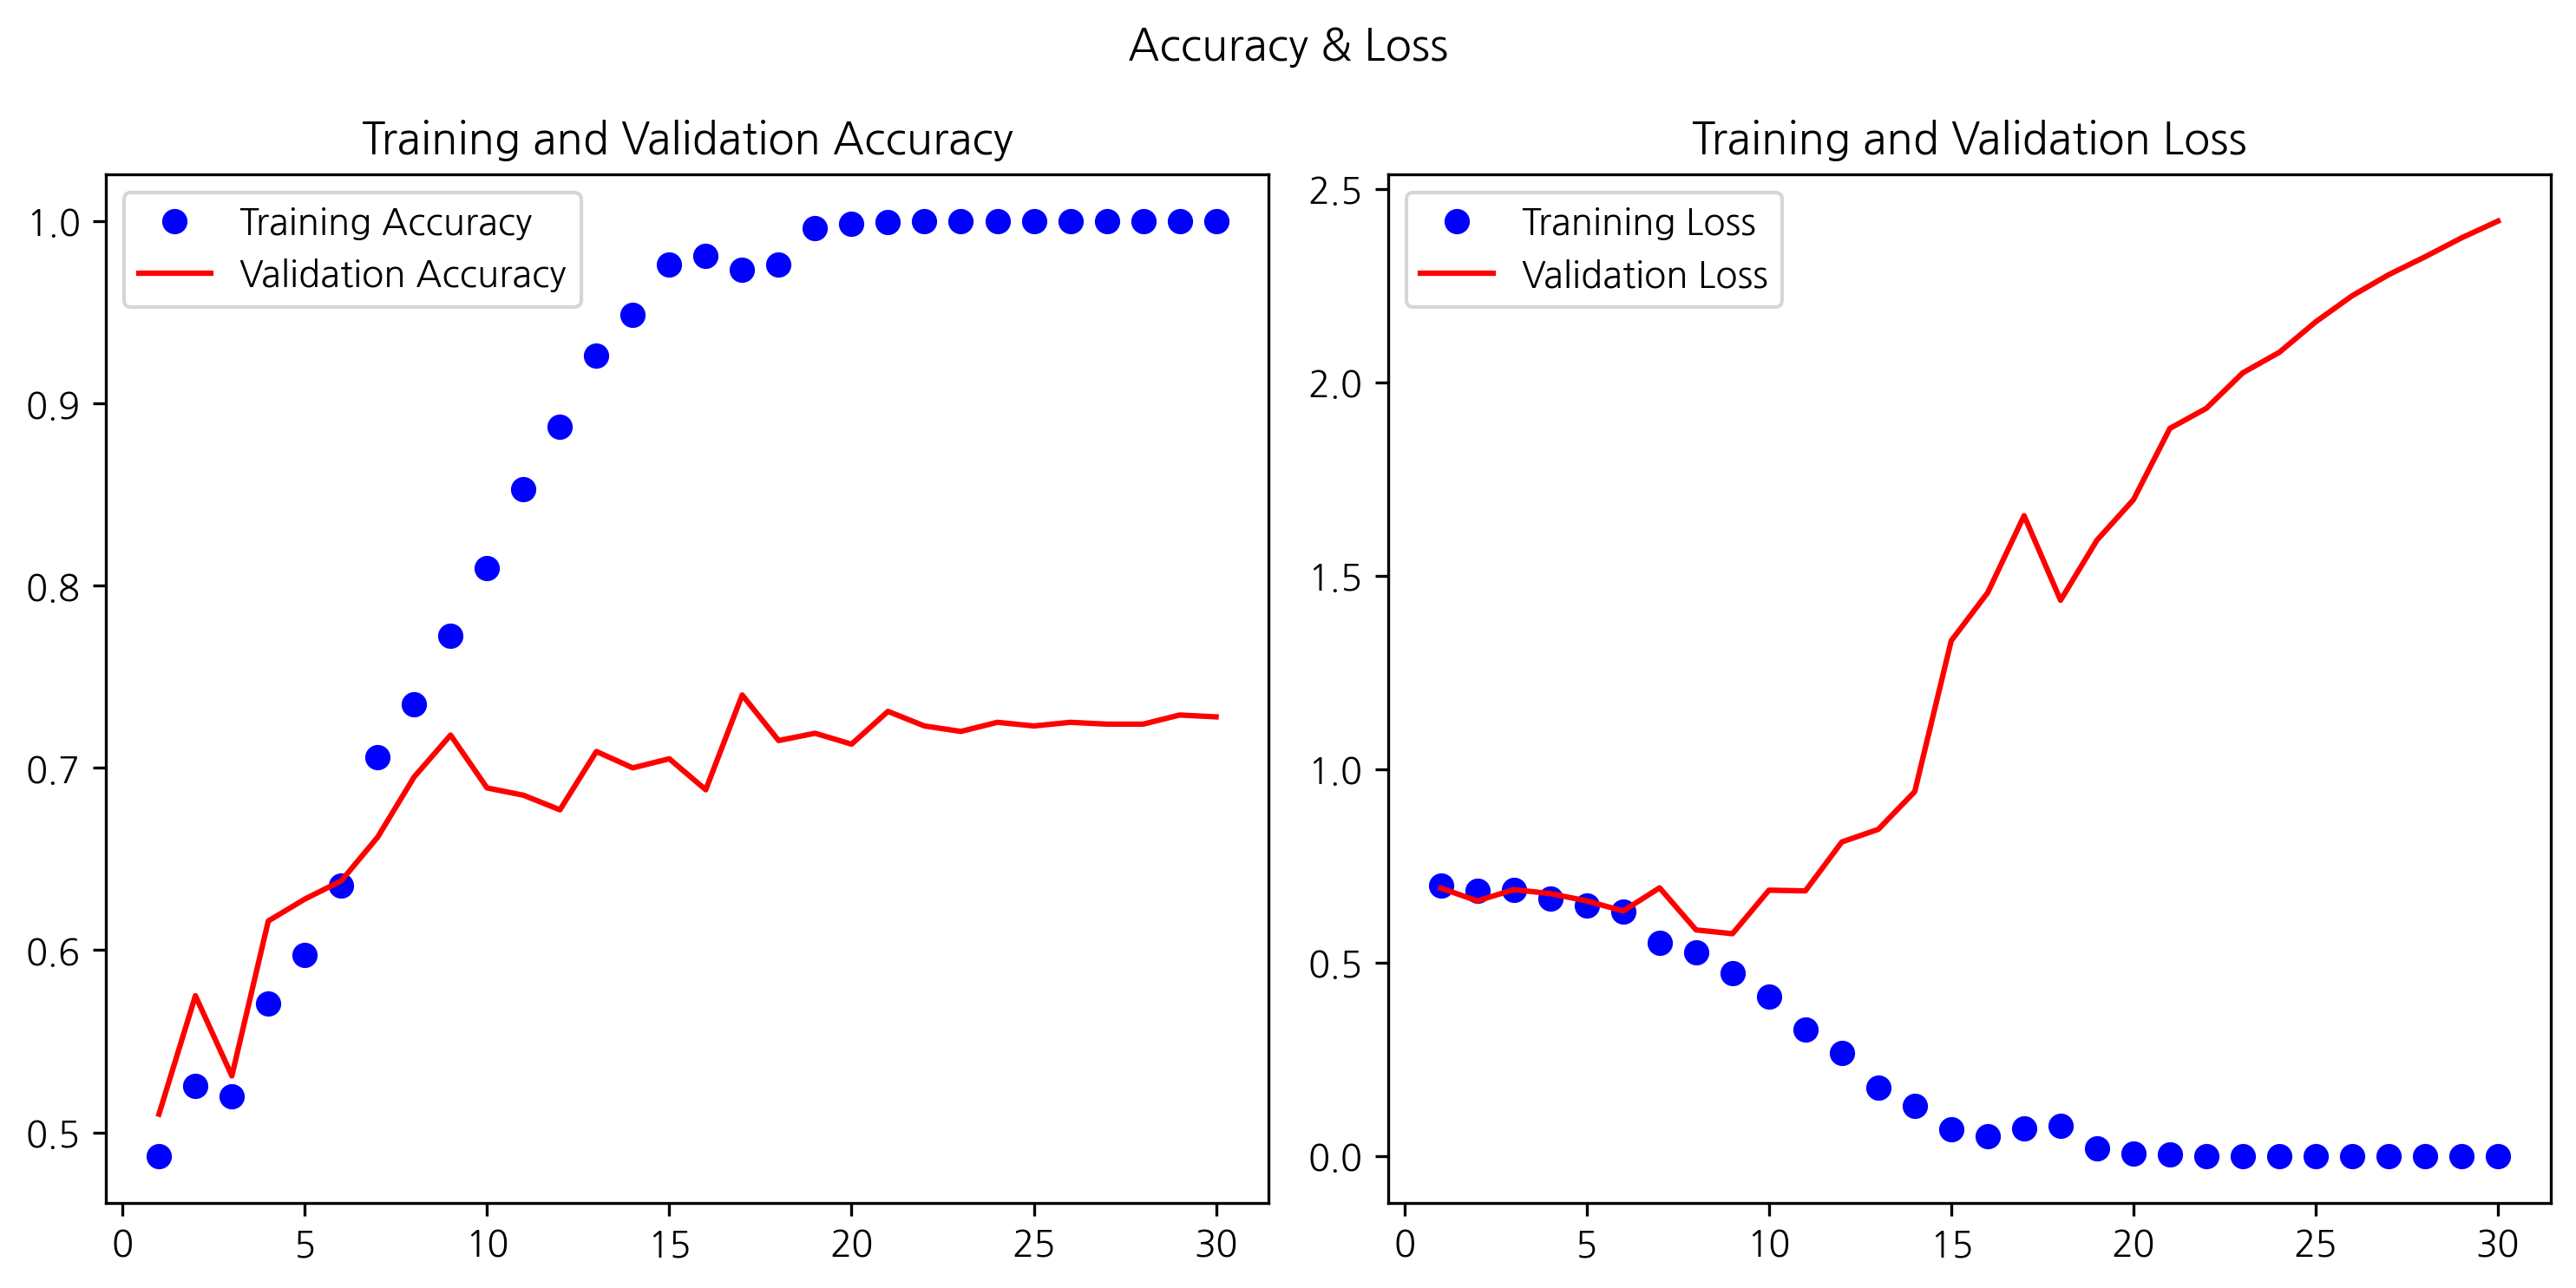

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend() 

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Tranining Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.suptitle('Accuracy & Loss')
plt.tight_layout()

plt.show() 

# 과대적합 억제하는 가장 좋은 방법 = 훈련 데이터 수를 늘리는 거다. 
# 데이터 증식을 통해 과대적합 억제해보자. 